In [3]:
import caffe
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import OrderedDict
import pprint as pp

# Read image using URL
from PIL import Image
import requests
from io import BytesIO

%matplotlib inline

### Define Net

In [4]:
CAFFE_ROOT = '/home/albert/caffe/'
prototxt_file = CAFFE_ROOT + 'models/Inception21k/train_val_pose.prototxt'
caffemodel_file = CAFFE_ROOT + 'models/Inception21k/Inception21k.caffemodel'

In [5]:
try:
    import textwrap
    textwrap.indent
except AttributeError:  # undefined function (wasn't added until Python 3.3)
    def indent(text, amount, ch=' '):
        padding = amount * ch
        return ''.join(padding+line for line in text.splitlines(True))
else:
    def indent(text, amount, ch=' '):
        return textwrap.indent(text, amount * ch)

In [12]:
def add_learn_param(layer, mult_dict={'weights':[1,1], 'biases':[2,0]}):
    header = "layer {\n"
    body = str(layer)
    l_param = \
"""param {
  lr_mult: %f
  decay_mult: %f
}
param {
  lr_mult: %f
  decay_mult: %f
}
""" % (mult_dict['weights'][0], mult_dict['weights'][1], 
       mult_dict['biases'][0], mult_dict['biases'][1])
    footer = "}\n"
    return(header + indent(body + l_param, 2) + footer)

In [13]:
def add_param(layer):
    header = "layer {\n"
    body = str(layer)
    footer = "}\n"
    return(header + indent(body, 2) + footer)

In [14]:
# https://github.com/BVLC/caffe/issues/4878
from caffe.proto import caffe_pb2
import google.protobuf.text_format as txtf

learn_net = caffe_pb2.NetParameter()
net_learnable_str = ''

prototxt_file = CAFFE_ROOT + \
                'models/Inception21k/train_val_pose.prototxt'

with open(prototxt_file) as f:
    s = f.read()
    txtf.Merge(s, learn_net)
    
    layerNames = [l.name for l in learn_net.layer]
    last_trainable_layer = layerNames.index('softmax')
    
    net_learnable_str += 'name: "%s"\n' % learn_net.name
    for l in range(len(learn_net.layer)):
        layer = learn_net.layer[l]
        if layer.type == "Convolution":
            net_learnable_str += add_learn_param(layer, 
                                                 mult_dict={'weights':[0.5,1], 'biases':[1,0]})
        elif layer.type == "InnerProduct":
            net_learnable_str += add_learn_param(layer)
        else:
            net_learnable_str += add_param(layer)

In [15]:
prototxt_file = CAFFE_ROOT + \
                'models/Inception21k/train_val_pose_learn_all.prototxt'
with open(prototxt_file, 'w') as f:
    f.write(net_learnable_str)

In [16]:
net = caffe.Net(prototxt_file, 
                     caffemodel_file, 
                     caffe.TRAIN)

In [17]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(5, 3, 128, 64)
label	(5,)
label_data_1_split_0	(5,)
label_data_1_split_1	(5,)
conv_conv1	(5, 96, 64, 32)
pool1	(5, 96, 32, 16)
conv_conv2red	(5, 128, 32, 16)
conv_conv2	(5, 288, 32, 16)
pool2	(5, 288, 16, 8)
pool2_pool2_0_split_0	(5, 288, 16, 8)
pool2_pool2_0_split_1	(5, 288, 16, 8)
pool2_pool2_0_split_2	(5, 288, 16, 8)
pool2_pool2_0_split_3	(5, 288, 16, 8)
conv_3a_1x1	(5, 96, 16, 8)
conv_3a_3x3_reduce	(5, 96, 16, 8)
conv_3a_3x3	(5, 96, 16, 8)
conv_3a_double_3x3_reduce	(5, 96, 16, 8)
conv_3a_double_3x3_0	(5, 144, 16, 8)
conv_3a_double_3x3_1	(5, 144, 16, 8)
ave_pool_3a_pool	(5, 288, 16, 8)
conv_3a_proj	(5, 48, 16, 8)
ch_concat_3a_chconcat	(5, 384, 16, 8)
ch_concat_3a_chconcat_ch_concat_3a_chconcat_0_split_0	(5, 384, 16, 8)
ch_concat_3a_chconcat_ch_concat_3a_chconcat_0_split_1	(5, 384, 16, 8)
ch_concat_3a_chconcat_ch_concat_3a_chconcat_0_split_2	(5, 384, 16, 8)
ch_concat_3a_chconcat_ch_concat_3a_chconcat_0_split_3	(5, 384, 16, 8)
conv_3b_1x1	(5, 96, 16, 8)
conv_3b_3x3_reduce	(5, 96

In [18]:
# The param shapes typically have the form 
# (output_channels, input_channels, filter_height, filter_width) (for the weights) 
# and the 1-dimensional shape (output_channels,) (for the biases).
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv_conv1	(96, 3, 7, 7) (96,)
bn_conv1	(96,) (96,)
scale_conv_conv1	(96,) (96,)
conv_conv2red	(128, 96, 1, 1) (128,)
bn_conv2red	(128,) (128,)
scale_conv_conv2red	(128,) (128,)
conv_conv2	(288, 128, 3, 3) (288,)
bn_conv2	(288,) (288,)
scale_conv_conv2	(288,) (288,)
conv_3a_1x1	(96, 288, 1, 1) (96,)
bn_3a_1x1	(96,) (96,)
scale_conv_3a_1x1	(96,) (96,)
conv_3a_3x3_reduce	(96, 288, 1, 1) (96,)
bn_3a_3x3_reduce	(96,) (96,)
scale_conv_3a_3x3_reduce	(96,) (96,)
conv_3a_3x3	(96, 96, 3, 3) (96,)
bn_3a_3x3	(96,) (96,)
scale_conv_3a_3x3	(96,) (96,)
conv_3a_double_3x3_reduce	(96, 288, 1, 1) (96,)
bn_3a_double_3x3_reduce	(96,) (96,)
scale_conv_3a_double_3x3_reduce	(96,) (96,)
conv_3a_double_3x3_0	(144, 96, 3, 3) (144,)
bn_3a_double_3x3_0	(144,) (144,)
scale_conv_3a_double_3x3_0	(144,) (144,)
conv_3a_double_3x3_1	(144, 144, 3, 3) (144,)
bn_3a_double_3x3_1	(144,) (144,)
scale_conv_3a_double_3x3_1	(144,) (144,)
conv_3a_proj	(48, 288, 1, 1) (48,)
bn_3a_proj	(48,) (48,)
scale_conv_3a_proj	(48,) (48,)
c

### Train Net

In [19]:
# Helper function for deprocessing preprocessed images, e.g., for display.
def deprocess_net_image(image):
    image = image.copy()              # don't modify destructively
    image = image[::-1]               # BGR -> RGB
    image = image.transpose(1, 2, 0)  # CHW -> HWC

    # clamp values in [0, 255]
    image[image < 0], image[image > 255] = 0, 255

    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)

    return image

In [20]:
caffe.set_mode_gpu()

net.forward()
market_data_batch = net.blobs['data'].data.copy()
market_label_batch = np.array(net.blobs['label'].data, dtype=np.int32)

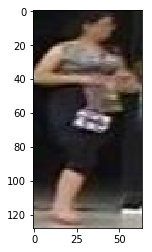

In [21]:
plt.imshow(deprocess_net_image(market_data_batch[3]))

In [22]:
solver_file = CAFFE_ROOT + 'models/Inception21k/solver_pose.prototxt'
solver = caffe.SGDSolver(solver_file)

In [23]:
iterations = 100000
test_interval = 1000
disp_interval = 100
train_loss = np.zeros(iterations)
train_acc = np.zeros(iterations)
test_acc = np.zeros(int(np.ceil(iterations / test_interval)))

blobs = ('loss', 'acc')
for it in range(iterations):
    solver.step(1)  # run a single SGD step in Caffe
    train_loss[it], train_acc[it] = (solver.net.blobs[b].data.copy()
                                             for b in blobs)
    if it % disp_interval == 0 or it + 1 == iterations:
        loss_disp = ('loss=%.3f, acc=%2d%%' %
                              (train_loss[it], np.round(100*train_acc[it])))
        print '%3d) %s: ' % (it, loss_disp)

    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['softmax'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

  0) loss=6.621, acc= 0%: 
Iteration 0 testing...
100) loss=6.606, acc= 0%: 
200) loss=6.597, acc= 0%: 
300) loss=6.635, acc= 0%: 
400) loss=6.520, acc= 0%: 
500) loss=6.745, acc= 0%: 
600) loss=6.575, acc= 0%: 
700) loss=6.474, acc= 0%: 
800) loss=6.634, acc= 0%: 
900) loss=6.477, acc= 0%: 
1000) loss=6.587, acc= 0%: 
Iteration 1000 testing...
1100) loss=6.453, acc= 0%: 
1200) loss=6.695, acc= 0%: 
1300) loss=6.458, acc= 0%: 
1400) loss=6.486, acc= 0%: 
1500) loss=6.560, acc= 0%: 
1600) loss=6.621, acc= 0%: 
1700) loss=6.460, acc= 0%: 
1800) loss=6.623, acc= 0%: 
1900) loss=6.391, acc= 0%: 
2000) loss=6.634, acc= 0%: 
Iteration 2000 testing...
2100) loss=6.413, acc= 0%: 
2200) loss=6.054, acc= 0%: 
2300) loss=6.462, acc= 0%: 
2400) loss=6.532, acc= 0%: 
2500) loss=6.478, acc= 0%: 
2600) loss=6.245, acc= 0%: 
2700) loss=6.720, acc= 0%: 
2800) loss=6.119, acc= 0%: 
2900) loss=6.689, acc= 0%: 
3000) loss=6.641, acc= 0%: 
Iteration 3000 testing...
3100) loss=6.184, acc= 0%: 
3200) loss=6.

26200) loss=6.298, acc= 0%: 
26300) loss=6.765, acc= 0%: 
26400) loss=6.738, acc= 0%: 
26500) loss=6.543, acc= 0%: 
26600) loss=6.479, acc= 0%: 
26700) loss=6.644, acc= 0%: 
26800) loss=6.654, acc= 0%: 
26900) loss=6.282, acc= 0%: 
27000) loss=6.425, acc= 0%: 
Iteration 27000 testing...
27100) loss=7.014, acc= 0%: 
27200) loss=6.116, acc= 0%: 
27300) loss=6.532, acc= 0%: 
27400) loss=6.621, acc= 0%: 
27500) loss=6.026, acc= 0%: 
27600) loss=6.363, acc= 0%: 
27700) loss=6.853, acc= 0%: 
27800) loss=6.209, acc= 0%: 
27900) loss=6.571, acc= 0%: 
28000) loss=6.547, acc= 0%: 
Iteration 28000 testing...
28100) loss=6.543, acc= 0%: 
28200) loss=6.440, acc= 0%: 
28300) loss=6.547, acc= 0%: 
28400) loss=6.850, acc= 0%: 
28500) loss=6.656, acc= 0%: 
28600) loss=6.525, acc= 0%: 
28700) loss=6.300, acc= 0%: 
28800) loss=6.191, acc= 0%: 
28900) loss=7.268, acc= 0%: 
29000) loss=6.595, acc= 0%: 
Iteration 29000 testing...
29100) loss=6.007, acc= 0%: 
29200) loss=5.991, acc= 0%: 
29300) loss=6.636, a

52100) loss=6.603, acc= 0%: 
52200) loss=6.943, acc= 0%: 
52300) loss=6.315, acc= 0%: 
52400) loss=6.623, acc= 0%: 
52500) loss=6.625, acc= 0%: 
52600) loss=6.629, acc= 0%: 
52700) loss=7.027, acc= 0%: 
52800) loss=6.895, acc= 0%: 
52900) loss=6.441, acc= 0%: 
53000) loss=6.738, acc= 0%: 
Iteration 53000 testing...
53100) loss=6.621, acc= 0%: 
53200) loss=5.965, acc= 0%: 
53300) loss=6.488, acc= 0%: 
53400) loss=6.451, acc= 0%: 
53500) loss=6.222, acc= 0%: 
53600) loss=6.307, acc= 0%: 
53700) loss=6.095, acc= 0%: 
53800) loss=7.172, acc= 0%: 
53900) loss=6.409, acc= 0%: 
54000) loss=6.193, acc= 0%: 
Iteration 54000 testing...
54100) loss=6.514, acc= 0%: 
54200) loss=6.562, acc= 0%: 
54300) loss=6.462, acc= 0%: 
54400) loss=6.490, acc= 0%: 
54500) loss=6.486, acc= 0%: 
54600) loss=6.393, acc= 0%: 
54700) loss=6.070, acc= 0%: 
54800) loss=6.333, acc= 0%: 
54900) loss=6.346, acc= 0%: 
55000) loss=6.289, acc= 0%: 
Iteration 55000 testing...
55100) loss=6.299, acc= 0%: 
55200) loss=6.430, a

78100) loss=6.547, acc= 0%: 
78200) loss=6.356, acc= 0%: 
78300) loss=6.547, acc= 0%: 
78400) loss=5.855, acc= 0%: 
78500) loss=6.730, acc= 0%: 
78600) loss=6.340, acc= 0%: 
78700) loss=6.552, acc= 0%: 
78800) loss=6.820, acc= 0%: 
78900) loss=6.585, acc= 0%: 
79000) loss=6.721, acc= 0%: 
Iteration 79000 testing...
79100) loss=6.730, acc= 0%: 
79200) loss=6.373, acc= 0%: 
79300) loss=6.810, acc= 0%: 
79400) loss=6.548, acc= 0%: 
79500) loss=6.701, acc= 0%: 
79600) loss=6.371, acc= 0%: 
79700) loss=6.402, acc= 0%: 
79800) loss=6.126, acc= 0%: 
79900) loss=6.676, acc= 0%: 
80000) loss=6.551, acc= 0%: 
Iteration 80000 testing...
80100) loss=6.592, acc= 0%: 
80200) loss=6.733, acc= 0%: 
80300) loss=6.400, acc= 0%: 
80400) loss=6.763, acc= 0%: 
80500) loss=6.637, acc= 0%: 
80600) loss=6.669, acc= 0%: 
80700) loss=6.423, acc= 0%: 
80800) loss=6.343, acc= 0%: 
80900) loss=6.416, acc= 0%: 
81000) loss=6.161, acc= 0%: 
Iteration 81000 testing...
81100) loss=6.260, acc= 0%: 
81200) loss=6.277, a

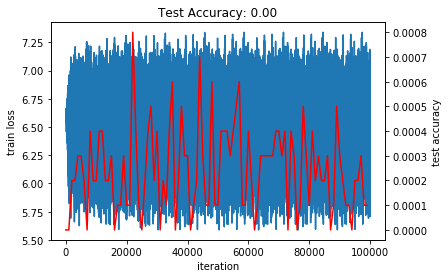

In [24]:
_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(iterations), train_loss)
ax2.plot(test_interval * np.arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))

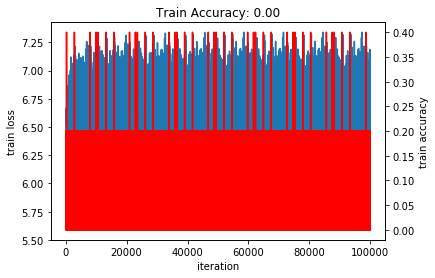

In [42]:
_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(iterations), train_loss)
ax2.plot(np.arange(iterations), train_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('train accuracy')
ax2.set_title('Train Accuracy: {:.2f}'.format(train_acc[-1]))

In [43]:
np.save(CAFFE_ROOT + 'models/Inception21k/train_loss.npy', train_loss)
np.save(CAFFE_ROOT + 'models/Inception21k/train_acc.npy', train_acc)
np.save(CAFFE_ROOT + 'models/Inception21k/test_acc.npy', test_acc)

### Evaluate Performance

In [27]:
labels = np.loadtxt(CAFFE_ROOT + 'data/market-1501/labels.txt',
                    str, delimiter='\t')

In [46]:
caffe.set_mode_gpu()

net.forward()
market_data_batch = net.blobs['data'].data.copy()
market_label_batch = np.array(net.blobs['label'].data, dtype=np.int32)

net.blobs['data'].data[0, ...] = market_data_batch[0]
output = net.forward()
output_prob = output['softmax'][0]
top_inds = output_prob.argsort()[::-1][:20]
output_classes = labels[top_inds.tolist()]

pp.pprint(zip(output_prob[top_inds], labels[top_inds].astype(np.uint16)))
print('Correct class: %s' % (labels[market_label_batch[0]]))

[(0.063460402, 611),
 (0.031770546, 190),
 (0.029310703, 551),
 (0.026866646, 594),
 (0.019285282, 1291),
 (0.016897947, 127),
 (0.016353469, 367),
 (0.013994735, 734),
 (0.013086661, 787),
 (0.011356927, 1025),
 (0.01118687, 564),
 (0.010753691, 1007),
 (0.0095343143, 314),
 (0.0094435839, 221),
 (0.0089019714, 1096),
 (0.008681477, 863),
 (0.0085486015, 1097),
 (0.0080116261, 552),
 (0.0077872169, 99),
 (0.0077847238, 670)]
Correct class: 430


In [55]:
def evaluate_rank(net, labels, rank, test_iter):
    correct = 0
    for it in range(test_iter):
        net.forward()
        market_data_batch = net.blobs['data'].data.copy()
        market_label_batch = np.array(net.blobs['label'].data, dtype=np.int32)

        net.blobs['data'].data[0, ...] = market_data_batch[0]
        output = net.forward()
        output_prob = output['softmax'][0]
        top_inds = output_prob.argsort()[::-1][:rank]
        output_classes = labels[top_inds].astype(np.uint16)
        
        if any(int(market_label_batch[0]) == c for c in output_classes):
            correct += 1
        
#         pp.pprint(zip(output_prob[top_inds], labels[top_inds].astype(np.uint16)))
#         print('Correct class: %s' % (labels[market_label_batch[0]]))    
    return float(correct)/test_iter

In [57]:
score = evaluate_rank(net, labels, 20, 1000)
print('Score: %.4f' % score)

Score: 0.0160
